First Print: 100 images
Second Print: 100 images


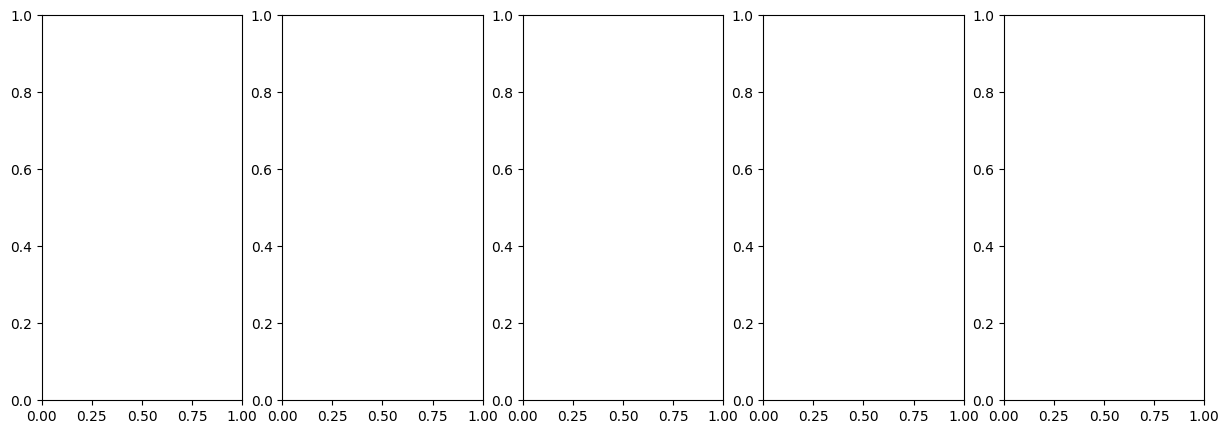

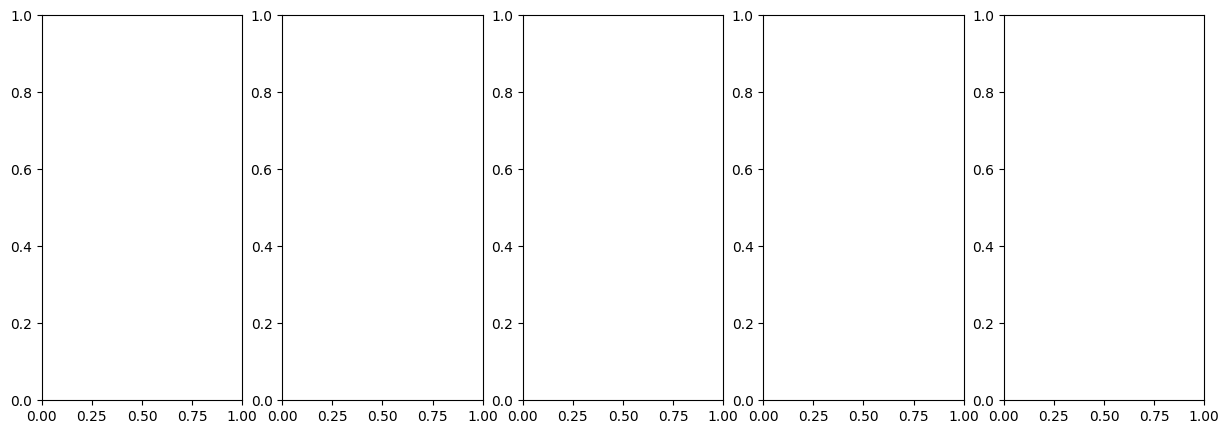

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define dataset path (update this with your actual path)
dataset_path = Path("Assignment Data")

# Check dataset structure
categories = ["First Print", "Second Print"]
for category in categories:
    category_path = dataset_path / category
    print(f"{category}: {len(os.listdir(category_path))} images")

# Load and display some sample images
def display_samples(category, num_samples=5):
    category_path = dataset_path / category
    sample_files = list(category_path.glob("*.png"))[:num_samples]  # Assuming images are PNGs
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, file in enumerate(sample_files):
        img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.show()

# Show samples from both classes
display_samples("first_print")
display_samples("second_print")

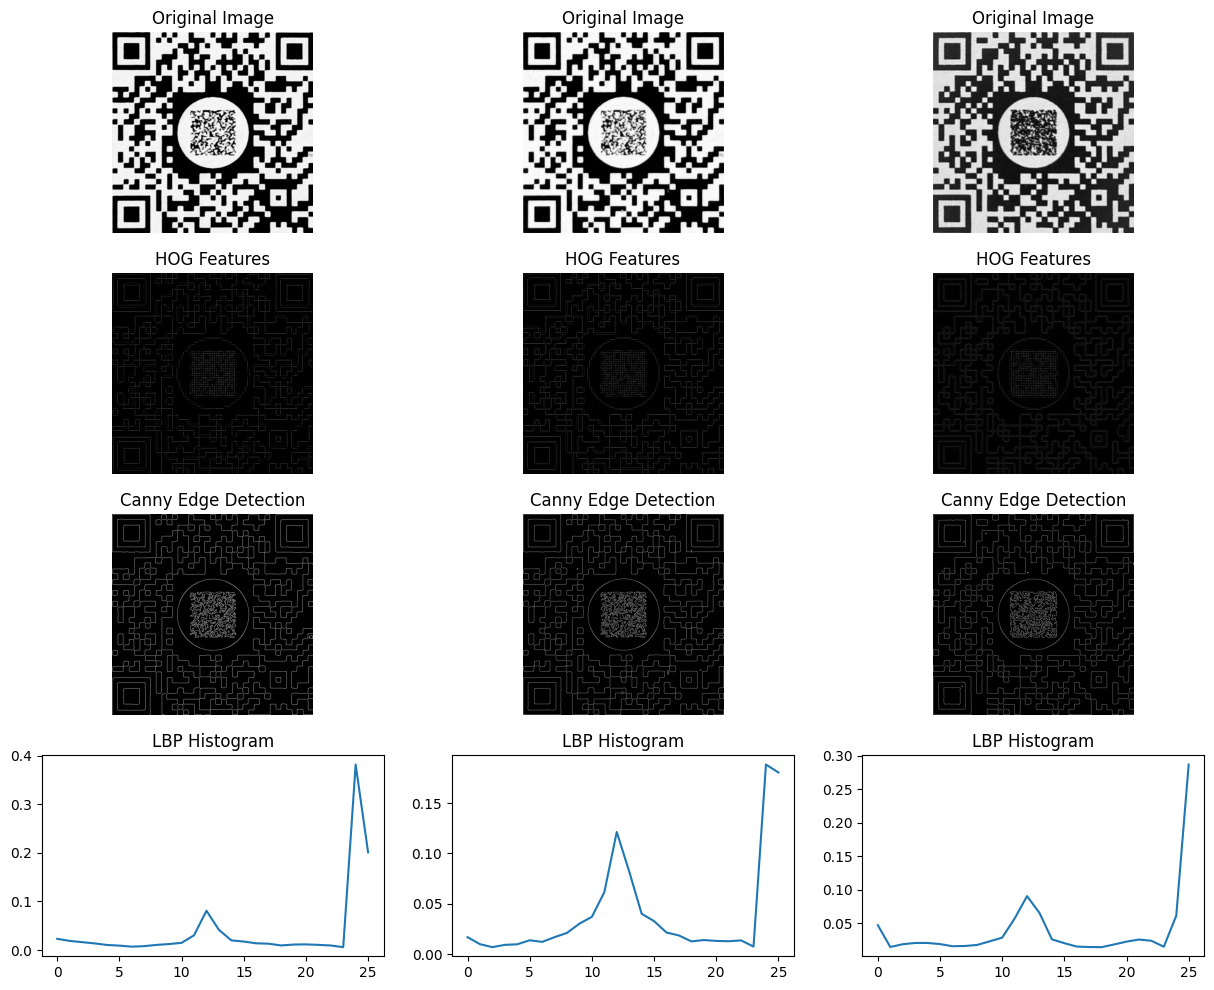

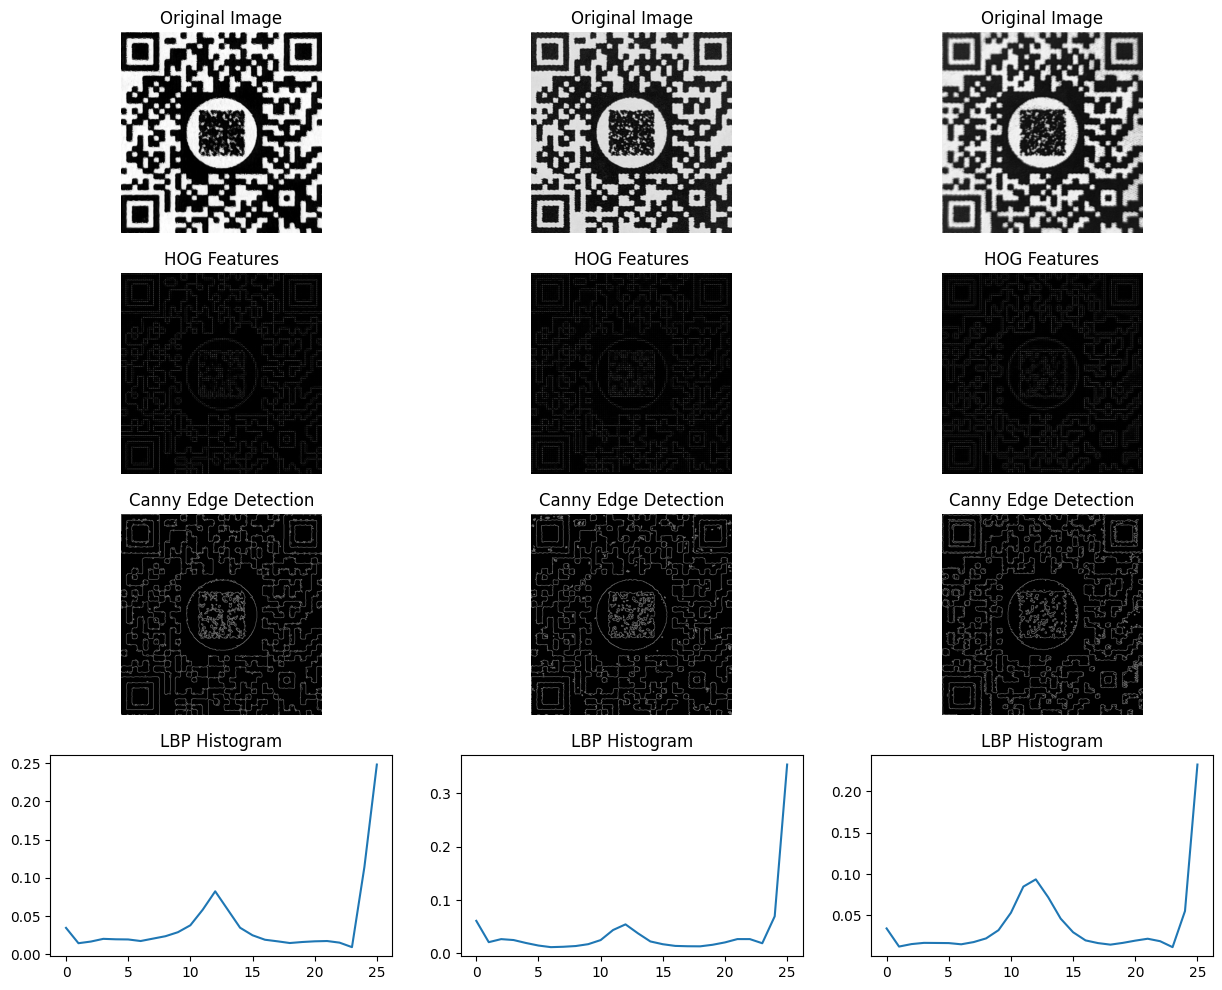

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
from scipy.stats import entropy
from pathlib import Path

# Feature Extraction Functions

# 1️⃣ Local Binary Pattern (LBP)
def extract_lbp_features(image):
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return hist

# 2️⃣ Histogram of Oriented Gradients (HOG)
def extract_hog_features(image):
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features, hog_image

# 3️⃣ Edge Detection (Sobel & Canny)
def extract_edge_features(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.Canny(image, 50, 150)
    return sobelx, sobely, edges

# 4️⃣ Statistical Features (Mean, Variance, Entropy)
def extract_statistical_features(image):
    mean = np.mean(image)
    variance = np.var(image)
    img_entropy = entropy(image.ravel())
    return mean, variance, img_entropy

# Load and extract features from sample images
def display_features(category, num_samples=3):
    category_path = dataset_path / category
    sample_files = list(category_path.glob("*.png"))[:num_samples]

    fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))

    for i, file in enumerate(sample_files):
        img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)

        # Extract features
        lbp_features = extract_lbp_features(img)
        hog_features, hog_image = extract_hog_features(img)
        sobelx, sobely, edges = extract_edge_features(img)

        # Display original image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("Original Image")
        axes[0, i].axis("off")

        # Display HOG features
        axes[1, i].imshow(hog_image, cmap='gray')
        axes[1, i].set_title("HOG Features")
        axes[1, i].axis("off")

        # Display Edge Detection
        axes[2, i].imshow(edges, cmap='gray')
        axes[2, i].set_title("Canny Edge Detection")
        axes[2, i].axis("off")

        # Display LBP Histogram
        axes[3, i].plot(lbp_features)
        axes[3, i].set_title("LBP Histogram")

    plt.show()

# Run feature extraction for both classes
display_features("First Print")
display_features("Second Print")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare dataset
X, y = [], []


def extract_features_and_labels(category, label):
    category_path = dataset_path / category
    for file in category_path.glob("*.png"):
        img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))  # Resize to 64x64 for faster processing

        # Extract features
        lbp_features = extract_lbp_features(img)
        hog_features, _ = extract_hog_features(img)
        mean, variance, img_entropy = extract_statistical_features(img)

        # Combine features
        features = np.hstack([lbp_features, hog_features, [mean, variance, img_entropy]])
        X.append(features)
        y.append(label)


# Extract features from both classes
extract_features_and_labels("First Print", 0)  # Label 0 for original
extract_features_and_labels("Second Print", 1)  # Label 1 for counterfeit

# Convert to DataFrame
X = np.array(X)
y = np.array(y)

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced trees for speed
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.83      1.00      0.90        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



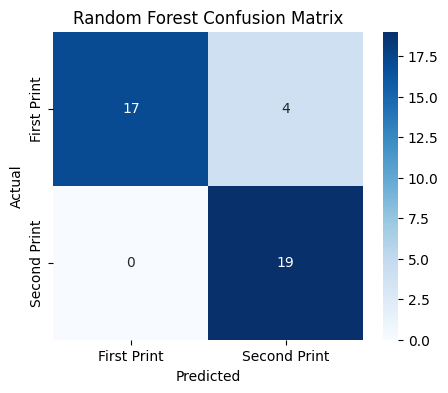

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(5,4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["First Print", "Second Print"], yticklabels=["First Print", "Second Print"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing
img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train CNN Model
cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate CNN
val_loss, val_acc = cnn_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4428 - loss: 2.4215 - val_accuracy: 0.5000 - val_loss: 0.7200
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6220 - loss: 0.7158 - val_accuracy: 0.7500 - val_loss: 0.5305
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7277 - loss: 0.5832 - val_accuracy: 0.9500 - val_loss: 0.4222
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8541 - loss: 0.4037 - val_accuracy: 0.9250 - val_loss: 0.3039
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8962 - loss: 0.3019 - val_accuracy: 0.8500 - val_loss: 0.2892
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9311 - loss: 0.2164 - val_accuracy: 0.8750 - val_loss: 0.2228
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9233 - loss: 0.2124 - val_accuracy: 0.9250 - val_loss: 0.1938
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9596 - loss: 0.1385 - val_accuracy: 0.9500 - val_loss: 0.1551
Epoch 9/10
5/5

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step


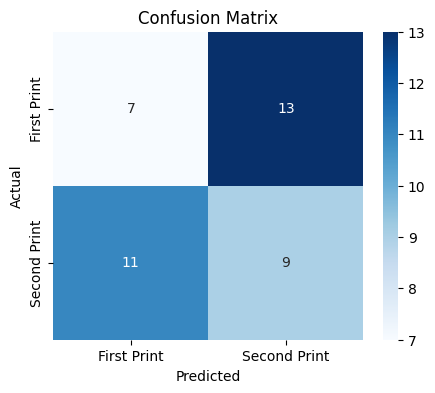

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = val_generator.classes
y_pred = (cnn_model.predict(val_generator) > 0.5).astype("int").flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["First Print", "Second Print"], yticklabels=["First Print", "Second Print"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()